Load Data

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Clean the Target

In [3]:
# Target: Yes/No -> 1/0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# TotalCharges sometimes has spaces; convert safely
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges (small number)
df = df.dropna(subset=["TotalCharges"])

df["Churn"].value_counts(normalize=True)


Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

Split Features

In [5]:
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]


Simple Baseline

In [12]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"   # 👈 THIS IS THE KEY
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Evaluation

In [14]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.8400083264637244
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1291
           1       0.50      0.80      0.61       467

    accuracy                           0.73      1758
   macro avg       0.70      0.75      0.70      1758
weighted avg       0.80      0.73      0.75      1758



Random Forest Model

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

Random Forest Evaluation

In [16]:
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print("RF ROC-AUC:", roc_auc_score(y_test, rf_proba))
print(classification_report(y_test, rf_pred))


RF ROC-AUC: 0.8131646035724178
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1291
           1       0.61      0.47      0.53       467

    accuracy                           0.78      1758
   macro avg       0.72      0.68      0.69      1758
weighted avg       0.77      0.78      0.77      1758



Although the Random Forest model was able to capture non-linear interactions between customer features, the Logistic Regression model achieved a higher ROC-AUC and stronger recall for churned customers. Since the primary business goal is to identify at-risk customers for retention efforts, recall and interpretability were prioritized. Therefore, Logistic Regression was selected as the final model for churn risk scoring.

Top 20

In [8]:
results = X_test.copy()
results["actual_churn"] = y_test.values
results["churn_probability"] = y_proba

results_sorted = results.sort_values("churn_probability", ascending=False)
results_sorted[["churn_probability", "actual_churn"]].head(20)


,churn_probability,actual_churn
3380,0.853958,1
6368,0.850490,1
3159,0.846897,0
2631,0.831055,1
4585,0.823570,1
935,0.822941,0
4517,0.822932,1
3727,0.818645,1
582,0.815941,1
2797,0.813459,1


Associations for Churn

In [9]:
import numpy as np

# Extract feature names after one-hot encoding
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([cat_feature_names, num_cols])
coefs = model.named_steps["clf"].coef_[0]

importance = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
}).sort_values("coef", ascending=False)

print("Most associated with CHURN:")
print(importance.head(15))

print("\nMost associated with NOT churning:")
print(importance.tail(15))


Most associated with CHURN:
                           feature      coef
44                    TotalCharges  0.647655
12     InternetService_Fiber optic  0.622179
32         Contract_Month-to-month  0.569338
28                 StreamingTV_Yes  0.211080
31             StreamingMovies_Yes  0.189194
14               OnlineSecurity_No  0.170910
23                  TechSupport_No  0.167866
39  PaymentMethod_Electronic check  0.156697
10               MultipleLines_Yes  0.098130
41                   SeniorCitizen  0.071445
17                 OnlineBackup_No  0.057463
22            DeviceProtection_Yes  0.030634
36            PaperlessBilling_Yes  0.009060
4                    Dependents_No -0.032085
20             DeviceProtection_No -0.046413

Most associated with NOT churning:
                                 feature      coef
26                        StreamingTV_No -0.226859
5                         Dependents_Yes -0.278492
8                       MultipleLines_No -0.291522
27       Str

Churn Risk

In [17]:
results = X_test.copy()
results["actual_churn"] = y_test.values
results["churn_probability"] = rf_proba

results = results.sort_values("churn_probability", ascending=False)
results.head(10)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,actual_churn,churn_probability
2927,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.90,69.90,0,1.000
1739,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.90,69.90,1,1.000
2194,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,Yes,No,Month-to-month,Yes,Electronic check,79.50,79.50,1,1.000
6764,Female,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.20,69.20,1,0.995
684,Female,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,No,Mailed check,71.10,71.10,0,0.995
1731,Female,1,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.60,69.60,1,0.995
809,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.55,69.55,1,0.995
3727,Female,0,No,No,3,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.60,291.90,1,0.985
3682,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.10,69.10,1,0.985
2631,Male,1,Yes,No,7,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.25,665.45,1,0.980


High-Risk Customers

In [18]:
high_risk = results[results["churn_probability"] >= 0.7]
high_risk.shape


(186, 21)

Patterns amongst high-risk customers

In [19]:
high_risk[["Contract", "MonthlyCharges", "tenure"]].describe()


,MonthlyCharges,tenure
count,186.000000,186.000000
mean,76.979570,6.370968
std,21.448166,8.868835
min,19.650000,1.000000
25%,70.262500,1.000000
50%,80.125000,3.000000
75%,93.800000,7.000000
max,106.700000,50.000000


High-rish vs Low-rish

In [20]:
low_risk = results[results["churn_probability"] < 0.3]
low_risk[["Contract", "MonthlyCharges", "tenure"]].describe()


,MonthlyCharges,tenure
count,1093.000000,1093.000000
mean,58.319671,41.774016
std,31.400272,22.962806
min,18.250000,1.000000
25%,24.250000,22.000000
50%,59.200000,46.000000
75%,85.450000,64.000000
max,118.750000,72.000000


ROC Curve

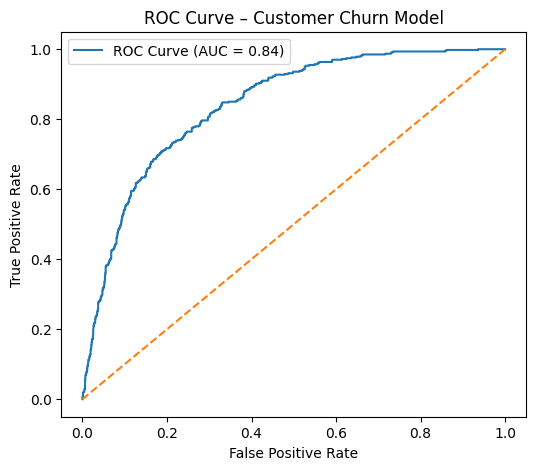

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Customer Churn Model")
plt.legend()
plt.show()


Top Churn Drivers Bar Chart

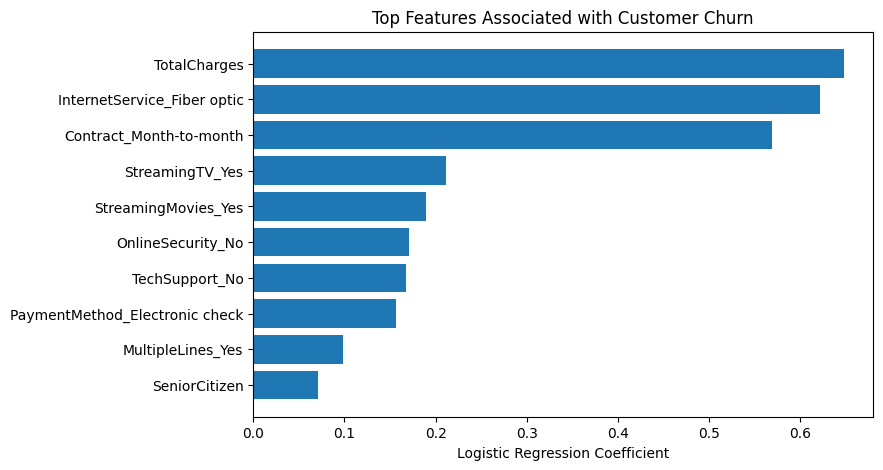

In [22]:
top_features = importance.sort_values("coef", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_features["feature"], top_features["coef"])
plt.gca().invert_yaxis()
plt.xlabel("Logistic Regression Coefficient")
plt.title("Top Features Associated with Customer Churn")
plt.show()


Business Action Plan:
Based on the churn risk predictions and feature analysis, customers on month-to-month contracts with high monthly charges and low tenure represent the highest churn risk segment. To reduce churn, the company should prioritize retention strategies for this group, including offering discounted long-term contracts, targeted loyalty incentives, or personalized onboarding support during the first few months of service. Proactively engaging these customers can help reduce churn and increase customer lifetime value.